In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd

from itertools import product
import math
import numpy as np
import random
from collections import defaultdict

from abc import ABCMeta, abstractmethod

# random.seed(42)


relevance = ["N", "R", "HR"]
rel_to_num = {"N":0, "R": 1, "HR":5}
r2binary = {"R": 1, "HR": 1, "N": 0}


### Simulate Rankings of Relevance for E and P

def create_rankings(k):
    
    possible_rankings = list(product(relevance, repeat=k*2))
    random.shuffle(possible_rankings)
    
    p = []
    e = []
    
    for ranking in possible_rankings:
        p.append(ranking[:k])
        e.append(ranking[k:])
        
    return p, e

k = 5
p, e = create_rankings(k)
# print(p)
# print(e)

### Precision at rank k 

def precision(ordering, rank):
    tp = 0
    for i in range(rank):
        tp += r2binary[ordering[i]]
    return tp/rank


### Normalized Discounted Cumulative Gain at rank k (nDCG@k)

def DCG(ranking, rank):
    DCG = 0
    for i in range(rank):
        DCG += (math.pow(2, rel_to_num[ranking[i]]) - 1)/(math.log(1 + (i+1), 2))
    return DCG

### calculate normalizing constants for all ranks

normalizing_constants = []
for i in range(1, 6):
    normalizing_constants.append(DCG(['HR'] * i, i))# calculate DCG for best possible ranking (all HR)

def nDCG(ranking, rank):
    #divide DCG by normalizing constant appropriate to considerate rank
    return DCG(ranking, rank) / normalizing_constants[rank - 1]

### Expected Reciprocal Rank

def ERR(ranking, rank):
    p = 1
    ERR = 0
    
    def probability(r):
        tmp = np.power(2, r)
        return (tmp - 1) / np.max(tmp)
    
    ranking = np.array([rel_to_num[ranking[i]] for i in range(rank)])
    
    R = probability(ranking)
    
    for r in range(rank):
        ERR += (p * R[r]) / (r+1)
        p *= 1 - R[r]
    
    return ERR



# compare the rankings from Production and the ranking from Experimental with a given measure.

def compare(p, e, k, measure):
    
    assert len(p) == len(e)
    assert k > 0
    
    results = []
    
    for r in range(len(p)):
        m_e = measure(e[r], k)
        m_p = measure(p[r], k)

        results.append(m_e - m_p)
    
    return results

def compute(k, rankings=None):
    if rankings is None:
        p, e = create_rankings(k)
    else:
        p, e = rankings

    assert len(p) == len(e)
    assert k > 0

    measures = {'precision': precision, 'nDCG': nDCG, 'ERR': ERR}
    results = {}

    for name, measure in measures.items():
        res = compare(p, e, k, measure)
        results[name] = 0
        for result in res:
            if result >= 0:
                results[name] += 1
        # results[name] = [(i, r) for i, r in enumerate(res) if r > 0]
        results[name] /= len(res)

    return results

res = compute(5)
print(res, "\n")


# PART 2: Interleaving

### TEAM DRAFT INTERLEAVING
def teamDraftInterleaving(rankingA, rankingB):
    interleaved_list = []
    team_assignment = []

    ranking = [rankingA, rankingB]
    count = [0, 0]
    
    while count[0] < len(ranking[0]) and count[1] < len(ranking[1]):
        assignment = 1 - int(count[0] < count[1] or (count[0] == count[1] and np.random.rand() > 0.5))
        
        team_assignment.append(assignment)
        interleaved_list.append(ranking[assignment][count[assignment]])
        count[assignment] += 1
    
    return interleaved_list, team_assignment


### PROBABILISTIC INTERLEAVING
def probabilisticInterleaving(rankingA, rankingB):
    # COIN = 0 for rankingA,  COIN = 1 for rankingB
    k = len(rankingA)  # rank

    interleaved_list = []  # final list of merged documents
    team_assignment = []  # from which ordering does a document come
    used = [[0, 0, 0, 0, 0], [0, 0, 0, 0, 0]]  # mark already inserted documents
    
    pdoc = []  # probability distributions of documents
    tau = 3
    
    
    ### check if document was already inserted into the merged list
    def is_used(n, used):
        i = 0
        while n > pdoc[i]:
            i += 1
        return -1 if used[i] else i
    
    
    ### take a document from the ordering chose by the coin flip following the distribution probab. in that ordering
    def get_doc(used):
        rand = random.uniform(0, 1)
        idx = is_used(rand, used)
        while idx == -1:
            rand = random.uniform(0, 1)
            idx = is_used(rand, used)
        return idx
    
    
    ### create distributions of documents based on ranking
    for i in range(k):
        pdoc.append(pdoc[-1] + 1 / np.power(i + 1, tau) if len(pdoc) > 0 else 1 / np.power(i + 1, tau))
    pdoc /= pdoc[-1]

    
    ### toss coins and add a document to the new list
    for i in range(k * 2):
        
        if used[0].count(1) == k:
            coin = 1
        elif used[1].count(1) == k:
            coin = 0
        else:
            coin = random.randint(0, 1)
        
        idx = get_doc(used[coin])
        if coin:
            interleaved_list.append(rankingB[idx])
        else:
            interleaved_list.append(rankingA[idx])
        
        used[coin][idx] = 1
        team_assignment.append(coin)
        
    return interleaved_list, team_assignment


def computeCredit(interleaved_list, team_assignment, clicks):
    assert len(interleaved_list) == len(clicks)
    assert len(interleaved_list) == len(team_assignment)

    credits = 0, 0

    for team, n_clicks in zip(team_assignment, clicks):
        credits[team] += n_clicks

    return credits


interleaved_list, team_assignment = probabilisticInterleaving(p[0], e[0])
# print(p[0])
# print(e[0])
# print(interleaved_list)
# print(team_assignment)





# PART 3: Click Models

# Abstract Click Model Class
class UserClickModel:
    __metaclass__ = ABCMeta

    @abstractmethod
    def train(self, trainingset):
        pass

    @abstractmethod
    def probabilities(self, ranking):
        pass

    def click(self, probabilities):
        return np.random.binomial(n=1, p=probabilities)
    
    @abstractmethod
    def parse(self, filename):
        pass


# Random Click Model
class RandomClickModel(UserClickModel):

    def __init__(self):
        self.p = 0
    
    def train(self, trainingset):
        click_count, total_count = self.parse(trainingset)
        self.p = click_count/total_count
    
    def probabilities(self, ranking):
        return self.p * np.ones(len(ranking))

    def parse(self, filename):
        """
        Parses search sessions, formatted according to the Yandex Relevance Prediction Challenge (RPC)
        (http://imat-relpred.yandex.ru/en/datasets).
        Returns a list of SearchSession objects.
        An RPC file contains lines of two formats:
        1. Query action
        SessionID TimePassed TypeOfAction QueryID RegionID ListOfURLs
        2. Click action
        SessionID TimePassed TypeOfAction URLID
        
        :param filename: The name of the file with search sessions formatted according to RPC.
        :returns: total count
        """
    
        file = open(filename, "r")
        
        click_count = 0
        total_count = 0
        
        for line in file:
        
            entry_array = line.strip().split("\t")
        
            # If the entry has 6 or more elements it is a query
            if len(entry_array) >= 6 and entry_array[2] == "Q":
                task = entry_array[0]
                docs = set(entry_array[5:])
                total_count += len(docs)
                
            # If the entry has 4 elements it is a click
            elif len(entry_array) == 4 and entry_array[2] == "C":
                doc = entry_array[3]
            
                if entry_array[0] == task and doc in docs:
                    click_count += 1
        
            # Else it is an unknown data format so leave it out
            else:
                continue
    
        return click_count, total_count


# Position-Based Model
class PositionBasedModel(UserClickModel):

    def __init__(self):
        self.gammas = []
        self.alphadict = {"N": 0.05, "R": 0.5, "HR": 0.95}
    
    def train(self, trainingset):
        documents, ranking = self.parse(trainingset)


        alphas = {}
        gammas = [0.1] * 10

        for document_id, document in documents.items():
            for query in document.keys():
                alphas[(document_id, query)] = 0.1

        epochs = 10

        for epoch in range(epochs):
            for document_id, document in documents.items():
                for query, occurrencies in document.items():
                    sum = 0
                    counter = 0

                    for list1 in occurrencies:
                        rank = list1[0]
                        click = list1[1]
                        if click:
                            counter += 1
                        alpha = alphas[(document_id, query)]
                        gamma = gammas[rank]

                        sum += click + (1 - click)*(1 - gamma)*alpha/(1 - gamma*alpha)

                    alphas[(document_id, query)] = sum / len(occurrencies)
                    #print("counterd o2c", counter)
                # query2sum = defaultdict(lambda: 0)
                # query2occurrencies = defaultdict(lambda: 0)
                # for query, ranking, click in document:
                #     alpha = alphas[(document, query)]
                #     gamma = gammas[ranking]
                #     query2sum[query] += click + (1 - click)*(1 - gamma)*alpha/(1 - gamma*alpha)
                #     query2occurrencies[query] += 1
                # for query, sum in query2sum.items():
                #     alphas[(document, query)] = sum/query2occurrencies[query]

            for i, rank in enumerate(ranking):
                sum = 0
                for query, document_id, click in rank:
                    alpha = alphas[(document_id, query)]
                    gamma = gammas[i]
                   # print((1 - alpha)*gamma / (1 - gamma*alpha))
                    sum += click + (1 - click)*(1 - alpha)*gamma / (1 - gamma*alpha)
                gammas[i] = sum / len(rank)

            print(epoch, gammas)
            print(alphas["1627", "1974"])               #(list(alphas.keys()))[0]])

        self.gammas = gammas

    
    def probabilities(self, ranking):
        attractiveness = [self.alphadict[ranking[rank]] for rank in range(len(ranking))]
        probabilities = np.array(attractiveness) * np.array(self.gammas[:len(ranking)])
        #print(probabilities)
        return probabilities



    
    def parse(self, filename):
        """
        Parses search sessions, formatted according to the Yandex Relevance Prediction Challenge (RPC)
        (http://imat-relpred.yandex.ru/en/datasets).
        Returns a list of SearchSession objects.
        An RPC file contains lines of two formats:
        1. Query action
        SessionID TimePassed TypeOfAction QueryID RegionID ListOfURLs
        2. Click action
        SessionID TimePassed TypeOfAction URLID
        
        :param filename: The name of the file with search sessions formatted according to RPC.

        :returns: 2 dictionaries:\n
        \t\t 1- an inverted index associating to each document the list of the queries in which it was returned, its ranking is those queries and whether it has been clicked or not\n
        \t\t 2- a list of 10 elements containing for each rank value (0 to 9, i.e. the indexes in the list) a list containing for each query the following tuple (query_id, doc_id, clicked)\n
        """
        
        file = open(filename, "r")
        
        ranking = [[] for rep in range(10)]
        
        documents = {}

        docs = None
        query_id = None
        task = None
        
        for line in file:
            
            entry_array = line.strip().split("\t")
            
            # If the entry has 6 or more elements it is a query
            if len(entry_array) >= 6 and entry_array[2] == "Q":
                task = entry_array[0]
                query_id = entry_array[3]
                docs = entry_array[5:]
                
                for i, doc in enumerate(docs):

                    
                    if doc not in documents:
                        documents[doc] = {}
                    if query_id not in documents[doc]:
                        documents[doc][query_id] = []
                    
                    documents[doc][query_id].append([i, 0])
                    
                    ranking[i].append([query_id, doc, 0])

                docs = set(docs)

            # If the entry has 4 elements it is a click
            elif len(entry_array) == 4 and entry_array[2] == "C":
                doc = entry_array[3]
                
                if entry_array[0] == task and doc in docs:
                    rnk = documents[doc][query_id][-1][0]
                    documents[doc][query_id][-1][1] = 1
                    ranking[rnk][-1][2] = 1
            
            # Else it is an unknown data format so leave it out
            else:
                continue
        
        return documents, ranking


def modelPerformances(model, p, e, interleaver):
    wins = 0
    for index in range(len(p)):
        interleaved_list, team_assignment = interleaver(p[index], e[index])
        probs = model.probabilities(interleaved_list)



        clicks = model.click(probs)

        scores = [0, 0]  # p = 0, e = 1
        for j in range(len(clicks)):
            scores[team_assignment[j]] += clicks[j]

        wins += 1 if scores[1] >= scores[0] else 0

    return wins / len(p)


RCM = RandomClickModel()
PBM = PositionBasedModel()
RCM.train('YandexRelPredChallenge.txt')
PBM.train('YandexRelPredChallenge.txt')

n_experiments = 5

RCM_rate = 0
PBM_rate = 0
RCM_rate_p = 0
PBM_rate_p = 0
for experiment in range(n_experiments):

    RCM_rate += modelPerformances(RCM, p, e, teamDraftInterleaving)
    PBM_rate += modelPerformances(PBM, p, e, teamDraftInterleaving)
    #RCM_rate_p += modelPerformances(RCM, p, e, probabilisticInterleaving)
    #PBM_rate_p += modelPerformances(PBM, p, e, probabilisticInterleaving)

RCM_rate /= n_experiments
PBM_rate /= n_experiments
RCM_rate_p /= n_experiments
PBM_rate_p /= n_experiments

print("RCM: ", RCM_rate)
print("PBM: ", PBM_rate)
print("RCM_p: ", RCM_rate_p)
print("PBM_p: ", PBM_rate_p)


    
    

{'ERR': 0.5020576131687243, 'precision': 0.6314586191129401, 'nDCG': 0.5020576131687243} 

0 [0.4940227198184552, 0.26421655167078173, 0.21484916688248143, 0.18495361606515562, 0.16394668243178673, 0.15091601874385782, 0.14411200832160814, 0.13836239551721927, 0.13409425846773923, 0.1364254475019879]
0.5454545454545454
1 [0.6782392732694802, 0.37862567229370464, 0.30213784514075764, 0.2525494718719197, 0.21681725280497188, 0.19394010770444528, 0.1819184677039079, 0.1714665423935836, 0.16381167913380512, 0.1680348219501454]
0.7344578354294388
2 [0.77654835773948, 0.4622312358896775, 0.37099056232219485, 0.308012946968641, 0.2617930634516717, 0.23127300394590383, 0.21517423814462927, 0.20074548862540925, 0.19035536387515192, 0.19614377813325953]
0.8160849861898201
3 [0.8361230741557306, 0.5266517475570843, 0.427575120766141, 0.35516981615388993, 0.30127600703299673, 0.26461959084300035, 0.24524477638685233, 0.22732719919407615, 0.21466840393467654, 0.22178483397674953]
0.8523435198065024

In [ ]:
interleaving = {'teamDraftInterleaving':teamDraftInterleaving, 'probabilisticInterleaving':probabilisticInterleaving}
clickmodels = {'RCM': RCM, 'PBM': PBM}

for i_name, alg in interleaving.items():
    for c_name, model in clickmodels.items():
        print(i_name + ' + ' + c_name)
        scores = []
        for experiment in range(5):
            scores += modelPerformances_list(model, p, e, alg)[0]

        plt.subplots()
        plt.title(i_name + ' + ' + c_name)
        plt.hist(scores, bins=17)
        plt.subplots()
        plt.title(i_name + ' + ' + c_name)
        sns.kdeplot(scores, bw=0.3)

Text(0.5,1,'PBM gammas')

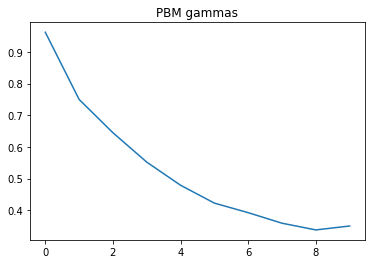

In [3]:
plt.plot(PBM.gammas)
plt.title('PBM gammas')

In [5]:
def online_performance(model, p, e, interleaver):
    scores_list = []
    wins = []
    for index in range(len(p)):
        interleaved_list, team_assignment = interleaver(p[index], e[index])
        probs = model.probabilities(interleaved_list)

        clicks = model.click(probs)

        scores = [0, 0]  # p = 0, e = 1
        for j in range(len(clicks)):
            scores[team_assignment[j]] += clicks[j]

        scores_list.append(scores[1] - scores[0])
        wins.append(1 if scores[1] > scores[0] else 0)

    return scores_list, wins


offline_measures = {'precision': precision, 'nDCG': nDCG, 'ERR': ERR}
online_measures = {'RCM': RCM, 'PBM': PBM}
interleavers = {'teamDraft': teamDraftInterleaving, 'probabilistic' : probabilisticInterleaving}

df = pd.DataFrame(columns=list(offline_measures.keys()) + [m + '_' + i for m in online_measures.keys() for i in interleavers.keys()])

for name, measure in offline_measures.items():
    df[name] = compare(p, e, k, measure)


N_EXP = 30
    
for m_name, measure in online_measures.items():
    for i_name, interleave in interleavers.items():
        name = m_name + '_' + i_name
        
        df[name] = 0
        for i in range(N_EXP):        
            scores, wins = online_performance(measure, p, e, interleave)
            df[name] += wins
        df[name] /= N_EXP

In [6]:
df.head()

,ERR,nDCG,precision,PBM_teamDraft,PBM_probabilistic,RCM_teamDraft,RCM_probabilistic
0,-0.619558,-0.156449,0.2,0.400000,0.300000,0.333333,0.333333
1,0.171347,-0.343449,0.2,0.300000,0.333333,0.400000,0.366667
2,0.000000,0.000000,0.0,0.400000,0.333333,0.433333,0.266667
3,0.074382,0.035705,0.0,0.233333,0.400000,0.200000,0.433333
4,0.149984,0.203046,0.0,0.433333,0.433333,0.300000,0.266667


In [7]:
from scipy.stats.stats import pearsonr

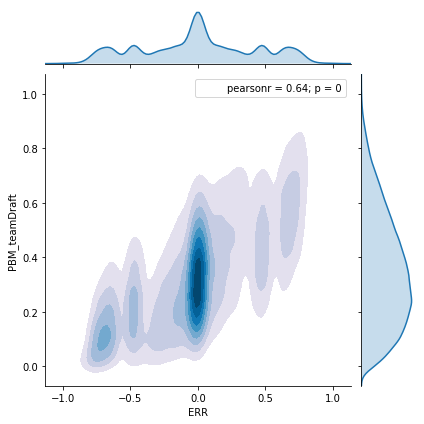

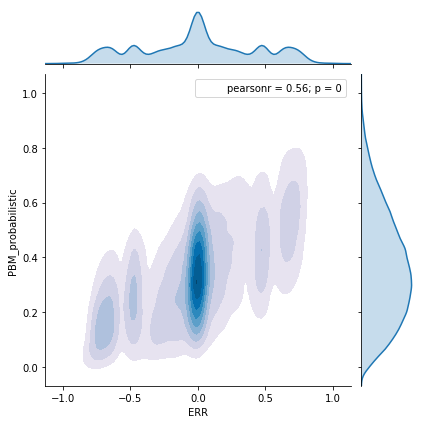

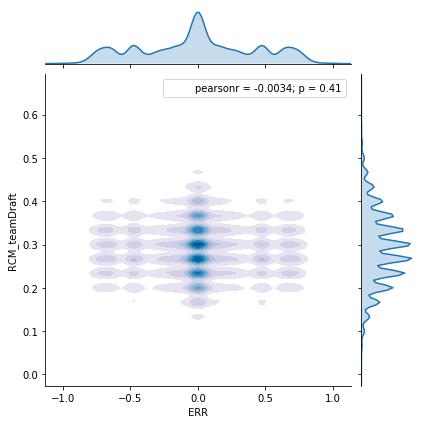

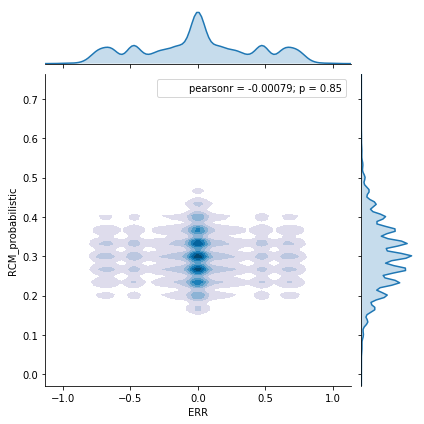

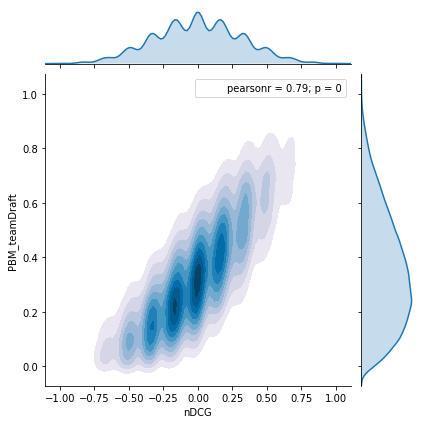

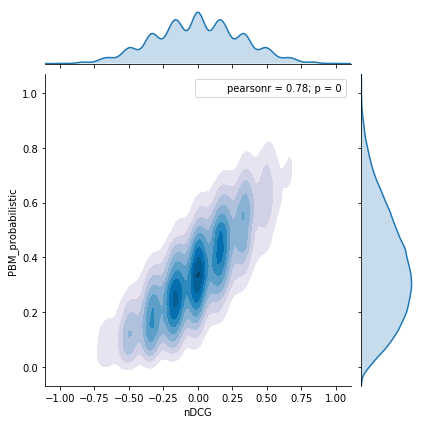

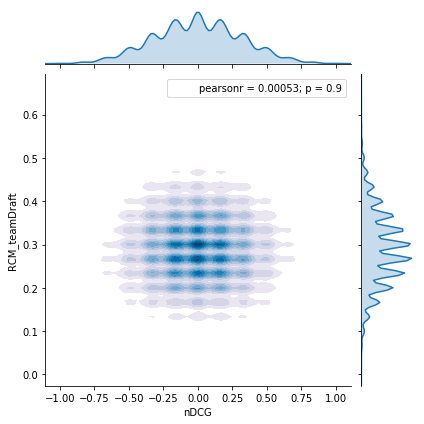

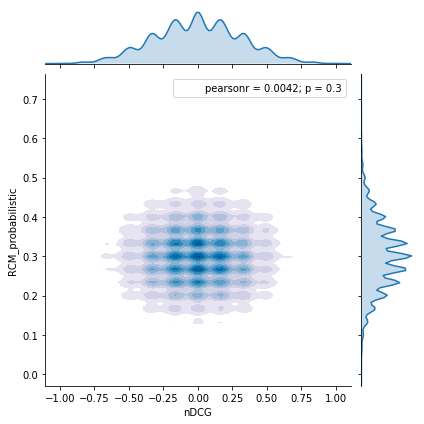

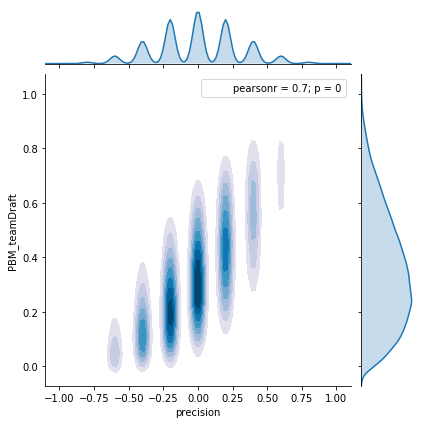

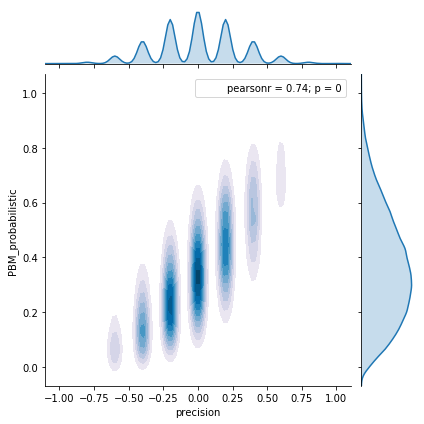

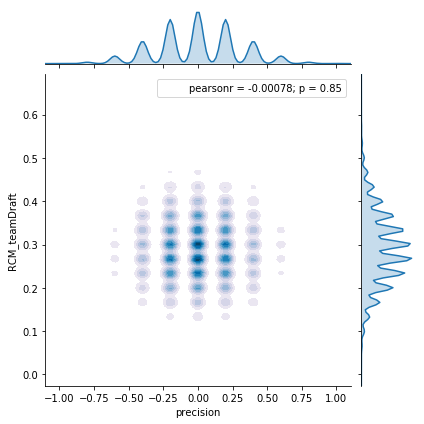

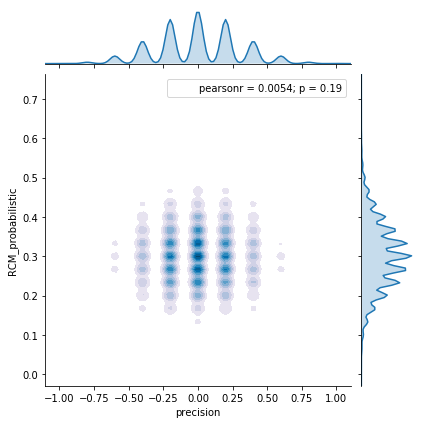

In [11]:
for off in offline_measures.keys():
    for on in online_measures.keys():
        for interleave in interleavers.keys():
            
            online = on + '_' + interleave
            
            g = sns.jointplot(x=off, y=online, data=df, kind="kde", shade = True, cmap = "PuBu")
            #g.plot_joint(plt.scatter, c="w", s=30, linewidth=1, marker="+")
            g.ax_joint.collections[0].set_alpha(0)
            #g.set_axis_labels("$X$", "$Y$")
        

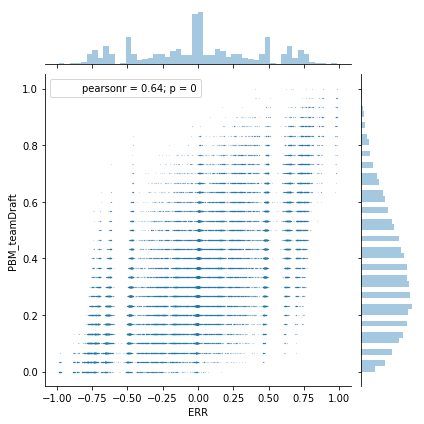

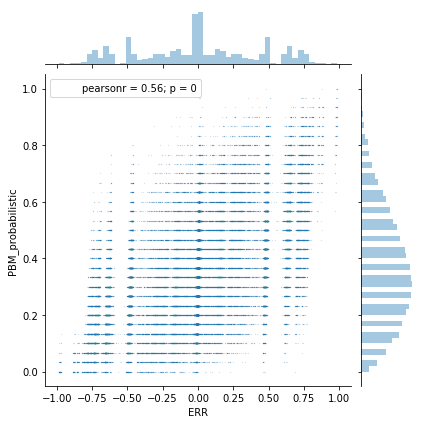

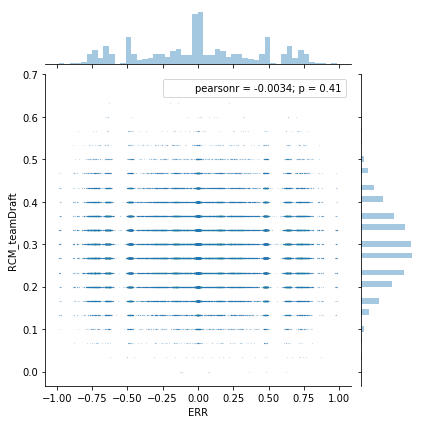

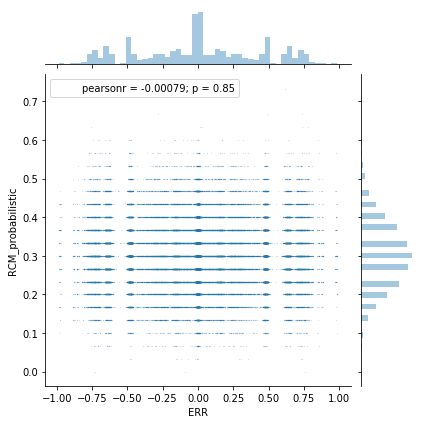

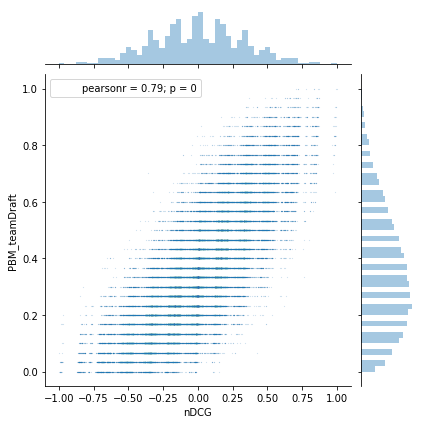

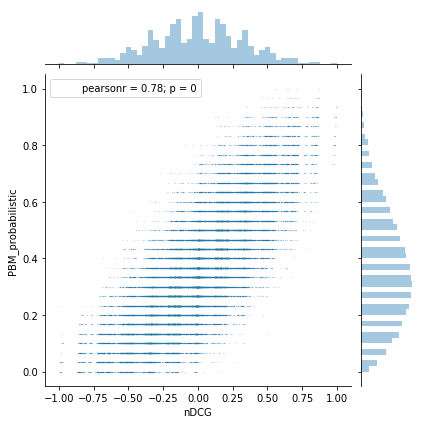

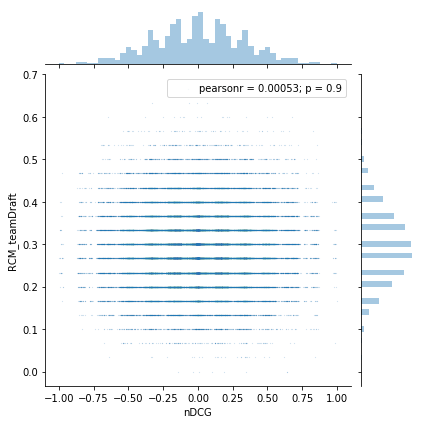

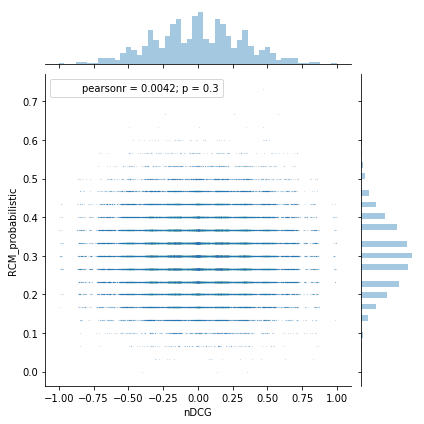

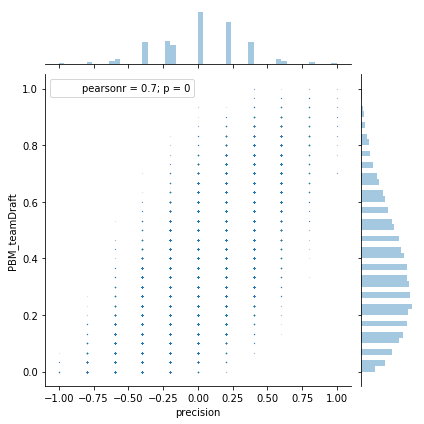

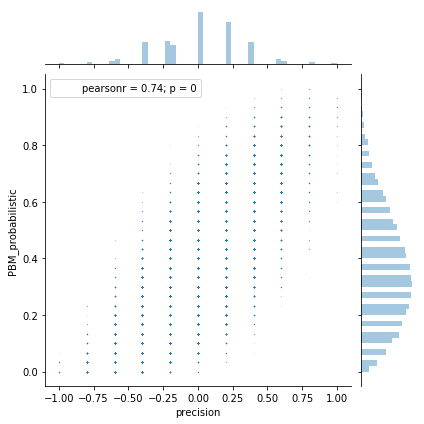

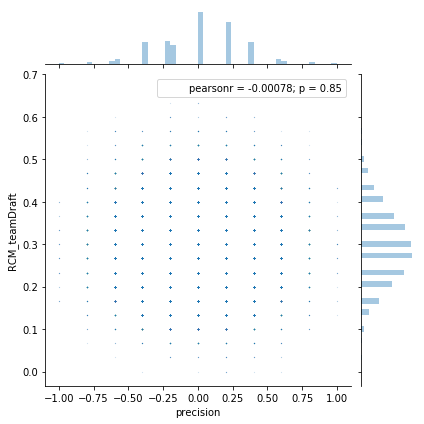

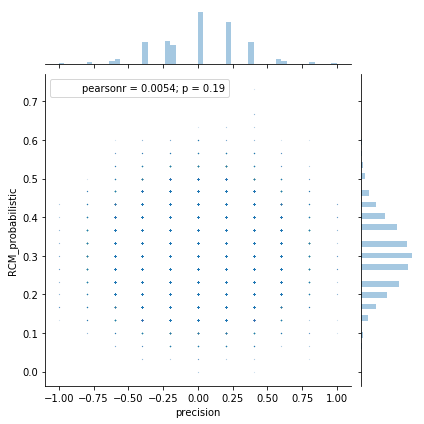

In [15]:
for off in offline_measures.keys():
    for on in online_measures.keys():
        for interleave in interleavers.keys():
            
            online = on + '_' + interleave
            g = sns.jointplot(x=off, y=online, data=df, s=0.005)
        
        

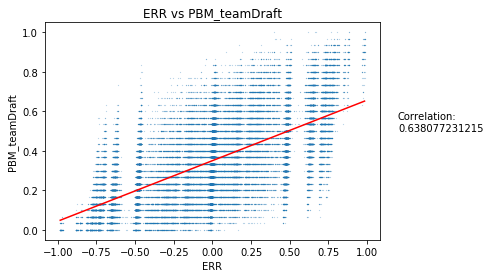

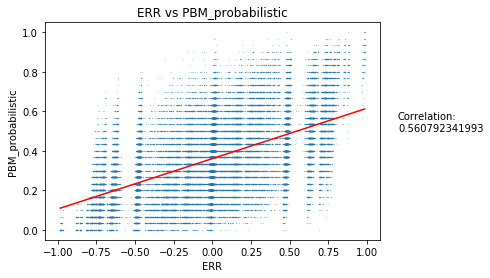

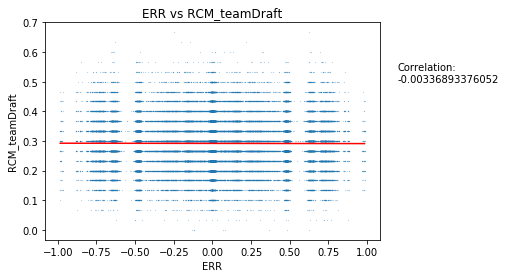

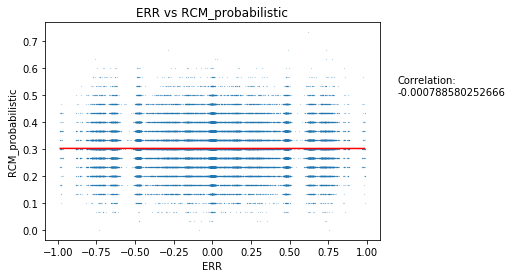

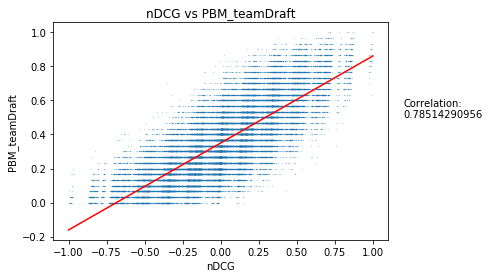

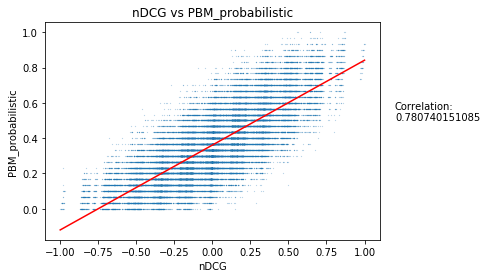

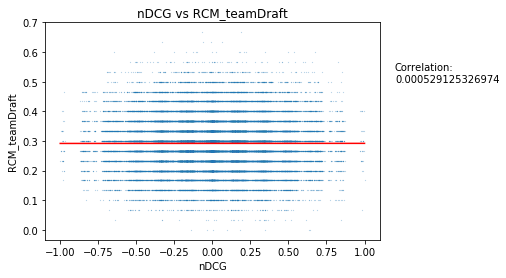

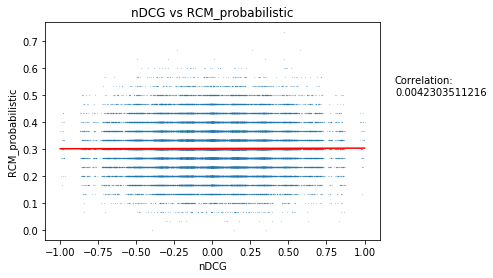

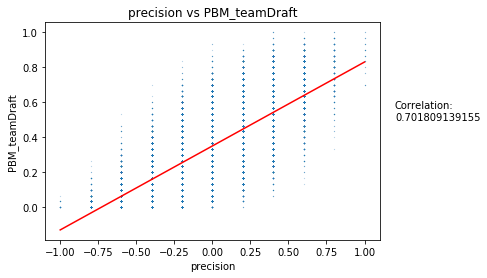

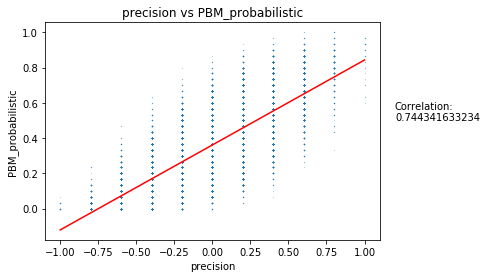

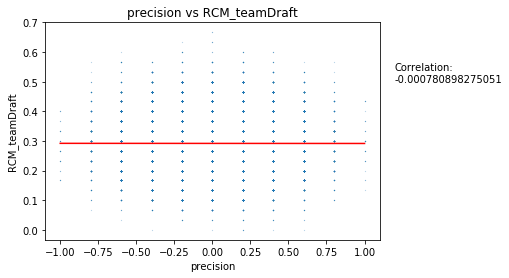

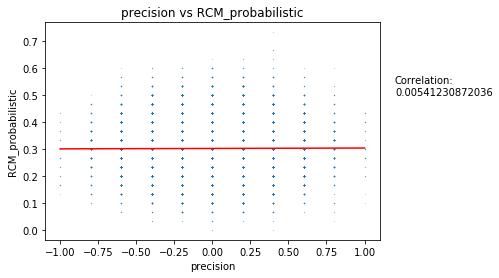

In [16]:
for off in offline_measures.keys():
    for on in online_measures.keys():
        for interleave in interleavers.keys():
            
            online = on + '_' + interleave

            plt.subplots()
            plt.scatter(df[off], df[online], marker='.', s=0.05)
            x = np.unique(df[off])
            line_params = np.polyfit(df[off], df[online], 1)
            slope = line_params[0]

            pearson_r = pearsonr(df[off], df[online])[0]

            y = np.poly1d(line_params)(x)
            plt.plot(x, y, 'red')
            plt.title(off + ' vs ' + online)
            plt.xlabel(off)
            plt.ylabel(online)
            plt.text(1.2, 0.5, 'Correlation:\n' + str(pearson_r))


In [17]:
cols_map = {1:'win', 0:'draw', -1:'loss'}
wins = pd.DataFrame(columns=list(cols_map.values()), index=list(offline_measures.keys()) + [m + '_' + i for m in online_measures.keys() for i in interleavers.keys()])
wins.fillna(0, inplace=True)
wins

,draw,win,loss
ERR,0,0,0
nDCG,0,0,0
precision,0,0,0
PBM_teamDraft,0,0,0
PBM_probabilistic,0,0,0
RCM_teamDraft,0,0,0
RCM_probabilistic,0,0,0


In [21]:
p, e = create_rankings(5)

for name, measure in offline_measures.items():
    print(name)
    results = compare(p, e, k, measure)
    for r in results:
        wins.loc[name, cols_map[np.sign(r)]] += 1

for m_name, measure in online_measures.items():
    for i_name, interleave in interleavers.items():
        name = m_name + '_' + i_name
    
        print(name)

        results = []
        for i in range(N_EXP):
            results += online_performance(measure, p, e, interleave)[0]

        for r in results:
            wins.loc[name, cols_map[np.sign(r)]] += 1

wins = wins.div(wins.sum(axis=1), axis=0)
wins

ERR
nDCG
precision
PBM_teamDraft
PBM_probabilistic
RCM_teamDraft
RCM_probabilistic


,draw,win,loss
ERR,0.004115,0.497942,0.497942
nDCG,0.004115,0.497942,0.497942
precision,0.262917,0.368541,0.368541
PBM_teamDraft,0.299678,0.350010,0.350312
PBM_probabilistic,0.278298,0.360927,0.360774
RCM_teamDraft,0.416188,0.292100,0.291712
RCM_probabilistic,0.395154,0.302554,0.302292


In [22]:
wins[['win', 'draw', 'loss']]

,win,draw,loss
ERR,0.497942,0.004115,0.497942
nDCG,0.497942,0.004115,0.497942
precision,0.368541,0.262917,0.368541
PBM_teamDraft,0.350010,0.299678,0.350312
PBM_probabilistic,0.360927,0.278298,0.360774
RCM_teamDraft,0.292100,0.416188,0.291712
RCM_probabilistic,0.302554,0.395154,0.302292


In [23]:
stats = [[], [], []]
for i in range(10):
    print(i)
    results = online_performance(PBM, p, e, teamDraftInterleaving)
    
    s = [0, 0, 0]
    
    for r in results:
        s[np.sign(r)] += 1
    
    t = sum(s)
    for i in range(3):
        stats[i].append(s[i]/t)

stats = pd.DataFrame(stats).transpose()
stats

0


TypeError: only integer scalar arrays can be converted to a scalar index

In [12]:
stats = [[], [], []]

for i in range(10):
    print(i)
    results = online_performance(PBM, p, e, probabilisticInterleaving)
    
    s = [0, 0, 0]
    
    for r in results:
        s[np.sign(r)] += 1
    
    t = sum(s)
    for i in range(3):
        stats[i].append(s[i]/t)

stats = pd.DataFrame(stats).transpose()
stats

0
1
2
3
4
5
6
7
8
9


,0,1,2
0,0.255923,0.371082,0.372995
1,0.257278,0.371302,0.371420
2,0.259005,0.367593,0.373402
3,0.255601,0.370235,0.374164
4,0.256380,0.370353,0.373266
5,0.254788,0.370895,0.374316
6,0.257786,0.370743,0.371471
7,0.256380,0.372640,0.370980
8,0.255280,0.371641,0.373080
9,0.256126,0.371099,0.372775


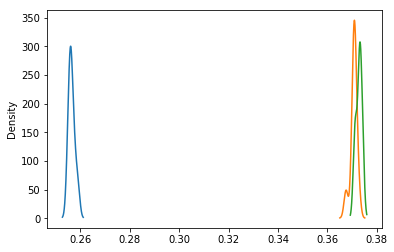

In [15]:
stats[0].plot.kde()
stats[1].plot.kde()
stats[2].plot.kde()